<a href="https://colab.research.google.com/github/scott-d-auca-2021/Neural-Networks/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Seminar_2_2_student_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__*Attribute Information:*__
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline

__*class:*__
- class_0
- class_1
- class_2

This is a copy of UCI ML Wine recognition datasets. https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

__*Original Owners:*__

Forina, M. et al, PARVUS - An Extendible Package for Data Exploration, Classification and Correlation. Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy.

__*Citation:*__

Lichman, M. (2013). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

__*References*__

(1) S. Aeberhard, D. Coomans and O. de Vel, Comparison of Classifiers in High Dimensional Settings, Tech. Rep. no. 92-02, (1992), Dept. of Computer Science and Dept. of Mathematics and Statistics, James Cook University of North Queensland. (Also submitted to Technometrics).

The data was used with many others for comparing various classifiers. The classes are separable, though only RDA has achieved 100% correct classification. (RDA : 100%, QDA 99.4%, LDA 98.9%, 1NN 96.1% (z-transformed data)) (All results using the leave-one-out technique)

(2) S. Aeberhard, D. Coomans and O. de Vel, “THE CLASSIFICATION PERFORMANCE OF RDA” Tech. Rep. no. 92-01, (1992), Dept. of Computer Science and Dept. of Mathematics and Statistics, James Cook University of North Queensland. (Also submitted to Journal of Chemometrics).

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Step 0. Data preparation

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Step 1. Preparing a neural network model

## Step 1.1. Model architecture

In [12]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(5)

## Step 1.2. Loss function

In [13]:
loss = torch.nn.CrossEntropyLoss()


## Step 1.3. Optimizer

In [14]:
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)

# Step 2. Training loop

In [4]:
np.random.permutation(5)

array([2, 0, 1, 4, 3])

In [17]:
batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()


      batch_indexes = order[start_index:start_index+batch_size]

      x_batch = X_train[batch_indexes]

      y_batch = y_train[batch_indexes]

      pred = wine_net.forward(x_batch)

      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())


tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)


# Step 3. Visualization of dividing surfaces.

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-11-4ffbf2cfa672>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  plt.scatter(X_train[indexes, 0],
<ipython-input-11-4ffbf2cfa672>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indexes, 0],


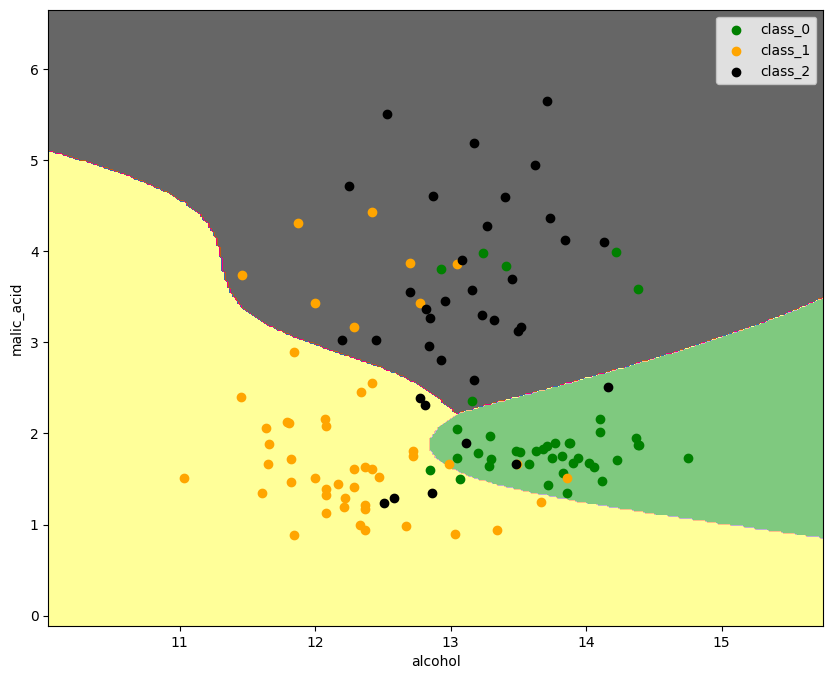

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0],
                X_train[indexes, 1],
                c=color,
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

# Step 4. Homework (60 points)

Let's practice with WineNet. Modify the architecture so that all 13 features are accepted as input and perform the following experiments:

1. Experiment with the number of neurons in the hidden layers. Try putting a very small number. Is there a threshold value for the number of hidden neurons at which learning becomes impossible?

2. Try passing different test_size values to the train_test_split function. At what value of test_size does the network predict worse than Base Rate*? And what is the Base Rate of the wine dataset?

3. Does the training time per epoch depend on the batch size? Explore this relationship.

As a report attach code and graphs that show all the necessary dependencies.

Task 1

15 neurons

In [19]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
#np.random.permutation(15)

batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())


tensor(0.2407)
tensor(0.4630)
tensor(0.6667)
tensor(0.7593)
tensor(0.8148)
tensor(0.8148)
tensor(0.7963)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)


22 neurons

In [20]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(22)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
##np.random.permutation(22)

batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())

tensor(0.4074)
tensor(0.7222)
tensor(0.8333)
tensor(0.7778)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)


44 neurons

In [21]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(44)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
#np.random.permutation(15)

batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())

tensor(0.4074)
tensor(0.7037)
tensor(0.8148)
tensor(0.8333)
tensor(0.8519)
tensor(0.8148)
tensor(0.8148)
tensor(0.7963)
tensor(0.8333)
tensor(0.8148)


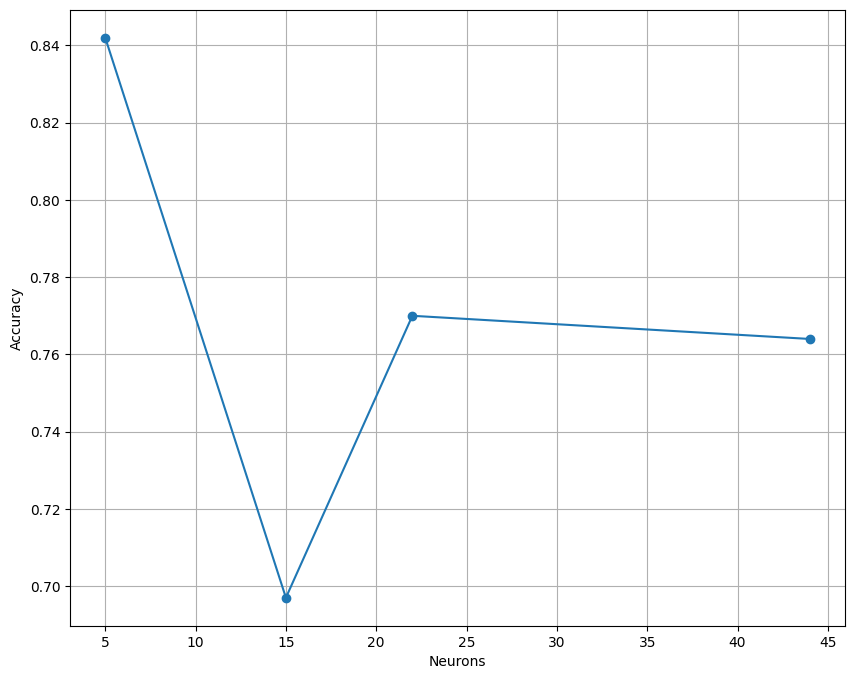

In [27]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

neurons = [5, 15, 22, 44]
accuracy = [0.842, 0.697, 0.77, 0.764]

plt.plot(neurons, accuracy, '-o')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Task 2

test_size 0.3

In [22]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
np.random.permutation(15)

batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())

tensor(0.2407)
tensor(0.4630)
tensor(0.6667)
tensor(0.7593)
tensor(0.8148)
tensor(0.8148)
tensor(0.7963)
tensor(0.8148)
tensor(0.8333)
tensor(0.8148)


test_size 0.5

In [23]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.5,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
np.random.permutation(15)

batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())

tensor(0.2697)
tensor(0.5056)
tensor(0.4382)
tensor(0.6180)
tensor(0.7191)
tensor(0.7416)
tensor(0.7528)
tensor(0.7528)
tensor(0.7528)
tensor(0.7640)


test_size 0.8

In [24]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.8,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
np.random.permutation(15)

batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())

tensor(0.2587)
tensor(0.3986)
tensor(0.5035)
tensor(0.5035)
tensor(0.5035)
tensor(0.5105)
tensor(0.5035)
tensor(0.5105)
tensor(0.5245)
tensor(0.5175)


test_size 0.1

In [25]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.1,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
np.random.permutation(15)

batch_size = 10

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      print((test_preds == y_test).float().mean())

tensor(0.2778)
tensor(0.5000)
tensor(0.6667)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)


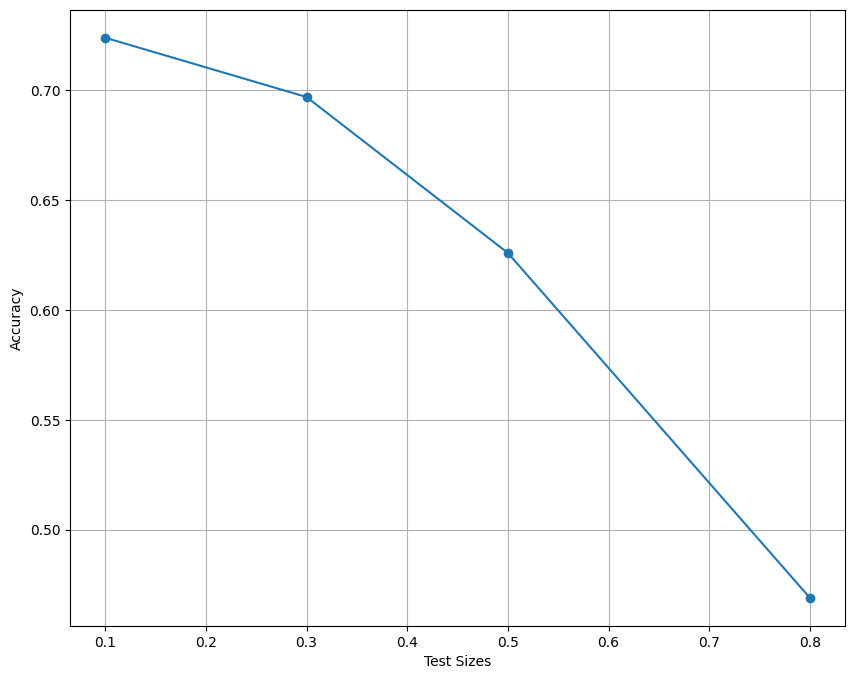

In [28]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

test_size = [0.1, 0.3, 0.5, 0.8]
accuracy = [0.724, 0.697, 0.626, 0.469]

plt.plot(test_size, accuracy, '-o')
plt.xlabel('Test Sizes')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Task 3

In [31]:
import torch
import random
import numpy as np
import time

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
#np.random.permutation(15)

batch_size = 5

time1 = time.time()

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      #print((test_preds == y_test).float().mean())

print(time.time() - time1)


45.794780254364014


In [32]:
import torch
import random
import numpy as np
import time

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
#np.random.permutation(15)

batch_size = 13

time1 = time.time()

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      #print((test_preds == y_test).float().mean())

print(time.time() - time1)


13.78000807762146


In [33]:
import torch
import random
import numpy as np
import time

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
      x = self.fc1(x)
      x = self.activ1(x)
      x = self.fc2(x)
      x = self.activ2(x)
      x = self.fc3(x)
      return x

    def inference(self, x):
      x = self.forward(x)
      x = self.sm(x)
      return x


wine_net = WineNet(15)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)
#np.random.permutation(15)

batch_size = 22

time1 = time.time()

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]
      x_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]
      pred = wine_net.forward(x_batch)
      loss_value = loss(pred, y_batch)
      loss_value.backward()

      optimizer.step()


    if epoch % 100 == 0:
      test_preds = wine_net.forward(X_test)
      test_preds = test_preds.argmax(dim=1)
      #print((test_preds == y_test).float().mean())

print(time.time() - time1)


8.104328393936157


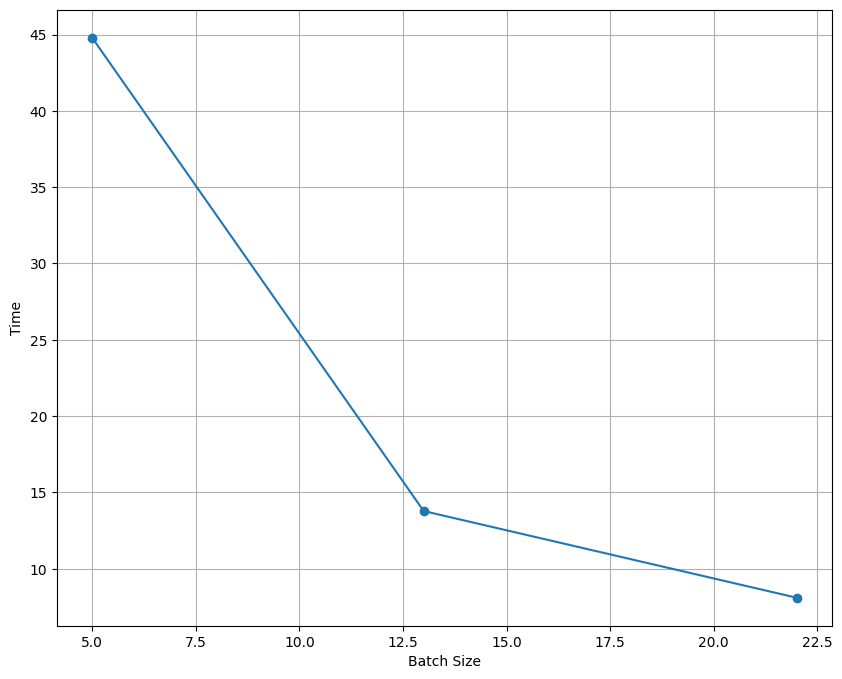

In [34]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

batch_s = [5, 13, 22]
tm = [44.79, 13.78, 8.1]

plt.plot(batch_s, tm, '-o')
plt.xlabel('Batch Size')
plt.ylabel('Time')
plt.grid(True)
plt.show()

The greater the Batch size, the faster is training time and the less the batch size, the slower is the training time.